# Tests

In [41]:
import numpy as np
import networkx as nx
from dwdynamics import ComplexDynamicsProblem, Objective # Difference a. We are using ComplexDynamicsProblem
import ptsymmetric
import dimod
import matplotlib.pyplot as plt
import json
import os
import minorminer
from dwave_networkx.generators.pegasus import (get_tuple_defragmentation_fn, fragmented_edges,
    pegasus_coordinates, pegasus_graph)
from dwave.system import DWaveSampler, EmbeddingComposite
import matplotlib.pyplot as plt
from collections import defaultdict
import re
from tqdm import tqdm


In [42]:
def create_instance(precision, number_time_points,instance_id = 1,  simplify = True):
    if instance_id == 1:
        SY = np.array([[0, -1.0j], [1.0j, 0.0]])
        PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.
        H = 0.5 * np.pi * SY
    if instance_id == 2:
        PSI0 = ptsymmetric.bell_state(state='00').full()
        H = ptsymmetric.generate_pt_symmetric_hamiltonian(2,seed=1).full()
    if instance_id == 3:
        PSI0 = np.array([1, 0], dtype=np.complex128)
        H = ptsymmetric.generate_pt_symmetric_hamiltonian(1,seed=1).full()


    # The problem object encapsulates all the data so you don't have to pass them around
    problem = ComplexDynamicsProblem(
        hamiltonian=H,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(number_time_points)),             # With six time points 0,1,2
        num_bits_per_var=precision                # And two bits of precision per variable
    )
    qubo = problem.qubo(objective=Objective.norm)  # Other choice would be to use Objective.hessian
    num_int = qubo.num_interactions + 1

    # for some reason multiple iterations over the qubo are necessary
    # to remove all 0 couplers
    if simplify:
        while (num_int > qubo.num_interactions):
            num_int = qubo.num_interactions
            for key,value in qubo.quadratic.items():
                if value == 0:
                    qubo.remove_interaction(key[0],key[1])

            
    assert qubo.num_variables == problem.hamiltonian.shape[0] * len(problem.times) * problem.num_bits_per_var * 2

    # save instances in the form 
    # systemid_{d}_precision_{d}_timepoints_{d}.json
    # systemid: {1: 0.5 * np.pi * SY}
    path = f"../data/instances/pruned/{instance_id}"
    file_name = os.path.join(path, f"precision_{precision}_timepoints_{number_time_points}.json")
    os.makedirs(path, exist_ok=True)
    with open(file_name,'w') as f:
        json.dump(qubo.to_serializable(),f)
    return qubo, PSI0, H


In [43]:
for precision in range(2,5):
    for timespoints in range(3,6):
        _, PSI0, H = create_instance(precision=precision,number_time_points=timespoints, instance_id=3)

In [44]:
H

array([[ 0.27568837+0.81330727j, -0.56996408-2.02317523j],
       [-0.56996408+2.02317523j,  0.27568837-0.81330727j]])

In [45]:
def get_sampleset(precision,timepoints,solver_id="5.4",instance_id = 1, simplify = True):
    """
    Runs ONE sample on the indicated D-Wave machine
    """
    qubo,_,_ = create_instance(precision, timepoints, instance_id, simplify)

    # The graph fo the problem is pretty dense, we use automatic embedding to mitigate the incompatibility with actual machine
    dw_sampler = ""
    if solver_id == "5.4":
        dw_sampler = EmbeddingComposite(DWaveSampler( solver="Advantage_system5.4", region="eu-central-1", ))
    elif solver_id == "2.6": # zephyr
        dw_sampler = EmbeddingComposite(DWaveSampler( solver="Advantage2_prototype2.6"))
    elif solver_id == "6.4": 
        dw_sampler = EmbeddingComposite(DWaveSampler(solver="Advantage_system6.4"))


    dw_result = dw_sampler.sample(qubo, num_reads=1000, annealing_time=200)

    return dw_result



In [46]:
def get_last_index(files):
    if files == []:
        return 0
    return max([int(re.findall('\d+(?=\.json)',file)[0]) for file in files])


In [ ]:
system = 3
prune = True
for solver in ["6.4"]:
    print(f"Solver {solver}")
    if prune:
        path = f"../data/results/pruned/{system}/{solver}"
    else:
        path = f"../data/results/notpruned/{system}/{solver}"

    os.makedirs(path, exist_ok=True)
    idx = get_last_index(os.listdir(path)) +1


    for i in tqdm(range(1,3),position = 0,desc=f"D-Wave Test on {solver}",leave=True): # number of tests
        idx = get_last_index(os.listdir(path)) +1
        for timepoints in tqdm([3,4,5],position = 1,desc="Timepoints",leave=False):
            for precision in [2,3,4]:
                dw_result = get_sampleset(solver_id=solver, precision=precision,timepoints=timepoints,instance_id=system, simplify=prune)
                
                file_name = os.path.join(path, f"precision_{precision}_timepoints_{timepoints}_{idx}.json")

                with open(file_name,'w') as f:
                    json.dump(dw_result.to_serializable(),f)

Solver 6.4


D-Wave Test on 6.4:  50%|█████     | 1/2 [01:50<01:50, 110.38s/it]


KeyboardInterrupt: embedding cancelled by keyboard interrupt

# Analyze

In [8]:
import os
import re
import pandas as pd
import numpy as np
import math
import dimod.sampleset


In [19]:
def load_data(pruned = True, raw = False,topology='5.4',system=1):
    if pruned:
        path = f'../data/results/pruned/{system}/'

    else:
        path = f'../data/results/notpruned/{system}/'
    dfs = []
    for topology in [topology]:
        path += topology
        for file in os.listdir(path):
            precision = int(re.findall('(?<=precision_)\d+',file)[0])
            timepoints = int(re.findall('(?<=timepoints_)\d+',file)[0])
            with open(os.path.join(path,file),'r') as f:
                s = dimod.SampleSet.from_serializable(json.load(f))
        
            s = s.to_pandas_dataframe()

            if not raw:
                s = s[['energy','num_occurrences']]
            s['systemid'] = topology
            s['precision'] = precision
            s['timepoints'] = timepoints
            dfs.append(s)

    dfs_all = pd.concat(dfs)

    return dfs_all

def get_precision_timepoints_pairs(dfs):
    dfs = dfs.groupby(['precision','timepoints'])['num_occurrences'].count()
    return list(set(dfs.index))

In [48]:
topology='6.4'
dfs_all = load_data(pruned = True,topology=topology,system=3)
dfs_all_rounded = dfs_all.copy()
dfs_all_rounded['energy'] = dfs_all_rounded['energy'].apply(lambda x: math.ceil(x)) # for displaying in a histogram

In [49]:
dfs_grouped =dfs_all.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum() 
dfs_grouped_rounded = dfs_all_rounded.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_keys = set([(key[0],key[1],key[2]) for key in dfs_grouped.keys()])
for key in dfs_keys:
    dfs_grouped[key] = dfs_grouped[key] / dfs_grouped[key].sum() * 100
    dfs_grouped_rounded[key] = dfs_grouped_rounded[key] / dfs_grouped_rounded[key].sum() * 100

dfs_grouped_rounded 

/tmp/ipykernel_37485/4200412015.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1
 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0

systemid  precision  timepoints  energy
6.4       2          3           2         0.4
                                 3         0.6
                                 4         4.6
                                 5         5.3
                                 6         7.0
                                          ... 
          4          5           111       0.1
                                 113       0.1
                                 115       0.1
                                 130       0.1
                                 138       0.1
Name: num_occurrences, Length: 558, dtype: float64

defaultdict(<class 'list'>, {4: [4, 2, 3], 3: [4, 2, 3], 5: [4, 2, 3]})
prec 2 timepoints 3
   energy  num_occurrences
0       2              0.4
1       3              0.6
2       4              4.6
3       5              5.3
4       6              7.0
prec 3 timepoints 3
   energy  num_occurrences
0       2              0.5
1       3              0.6
2       4              1.9
3       5              2.2
4       6              4.7
prec 4 timepoints 3
   energy  num_occurrences
0       2              0.1
1       3              0.3
2       4              0.8
3       5              2.1
4       6              1.9
prec 2 timepoints 4
   energy  num_occurrences
0       3              0.1
1       5              0.5
2       6              0.8
3       7              0.8
4       8              1.2
prec 3 timepoints 4
   energy  num_occurrences
0       5              0.3
1       6              0.1
2       7              0.6
3       8              0.9
4       9              1.2
prec 4 timepoints 

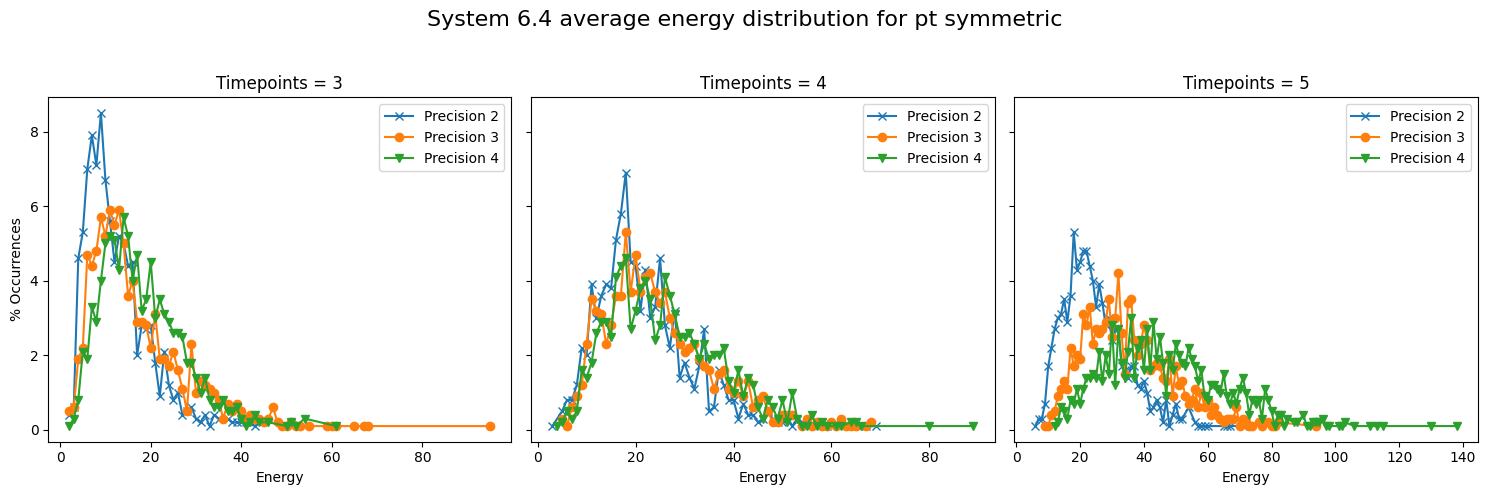

In [50]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey=True)
fig.suptitle(f"System {topology} average energy distribution for pt symmetric", fontsize=16)
markers = ['x','o','v']
prec_time_pairs = get_precision_timepoints_pairs(dfs_all)
timepoint_dict = defaultdict(list)
for timepoint_par in prec_time_pairs:
    timepoint_dict[timepoint_par[1]].append(timepoint_par[0])

print(timepoint_dict)
timepoints = sorted(timepoint_dict.keys())
for i, timepoint in enumerate(timepoints):
    ax = axes[i]
    for p in sorted(timepoint_dict[timepoint]):
        df = dfs_grouped_rounded[topology, p, timepoint].reset_index()
        print(f"prec {p} timepoints {timepoint}")
        print(df.head(5))
        ax.plot(df['energy'], df['num_occurrences'], label=f"Precision {p}", marker=markers[p-2])

    ax.set_xlabel('Energy')
    ax.set_title(f"Timepoints = {timepoint}")
    #ax.set_xlim(0, 200)
    if i == 0:
        ax.set_ylabel('% Occurrences')
    ax.legend()

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig('../plots/system54_energy_distribution.pdf')
plt.show()

# Simplification ?

In [20]:
dfs_not_pruned = load_data(pruned=False,precision_range=(2,3))
dfs_not_pruned

TypeError: load_data() got an unexpected keyword argument 'precision_range'

In [86]:
dfs_not_pruned['energy'] = round(dfs_not_pruned['energy'] +0.499) # for displaying in a histogram
dfs_not_pruned = dfs_not_pruned.groupby(['systemid', 'precision','timepoints','energy'])['num_occurrences'].sum()
dfs_not_pruned.head(3)

NameError: name 'dfs_not_pruned' is not defined

(0.0, 10.0)

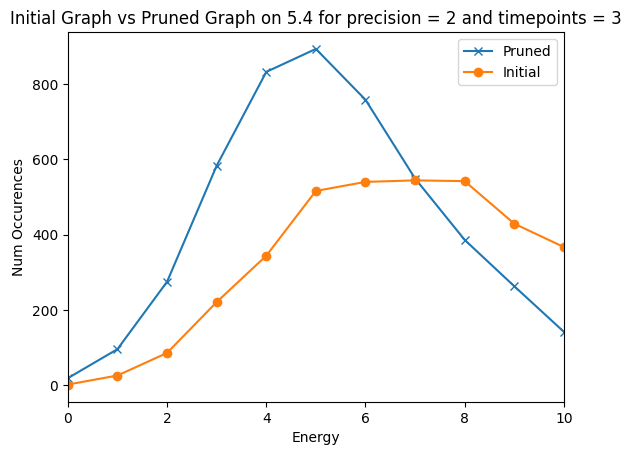

In [75]:
#plt.plot(dfs_not_pruned['energy'],dfs_not_pruned['num_occurrences'],label="Full graph",marker='o')
plt.plot(dfs_grouped['5.4',2,3],label="Pruned",marker='x')
plt.plot(dfs_not_pruned['5.4',2,3],label="Initial",marker='o')

plt.xlabel('Energy')
plt.title("Initial Graph vs Pruned Graph on 5.4 for precision = 2 and timepoints = 3")
plt.ylabel('Num Occurences')
plt.legend()

plt.xlim(0,10)

-more qubits
-pt symmetric eq 12 paper
- include specific machine

In [23]:
system

3

# Interpret results

In [23]:
dfs_data_raw = load_data(raw=True,topology=topology,system=system)
tp_pairs = get_precision_timepoints_pairs(dfs_data_raw)
tp_pairs.sort(key=lambda x: x[0]*10 + x[1])
dfs_data_raw['systemid']

0      5.4
1      5.4
2      5.4
3      5.4
4      5.4
      ... 
902    5.4
903    5.4
904    5.4
905    5.4
906    5.4
Name: systemid, Length: 26011, dtype: object

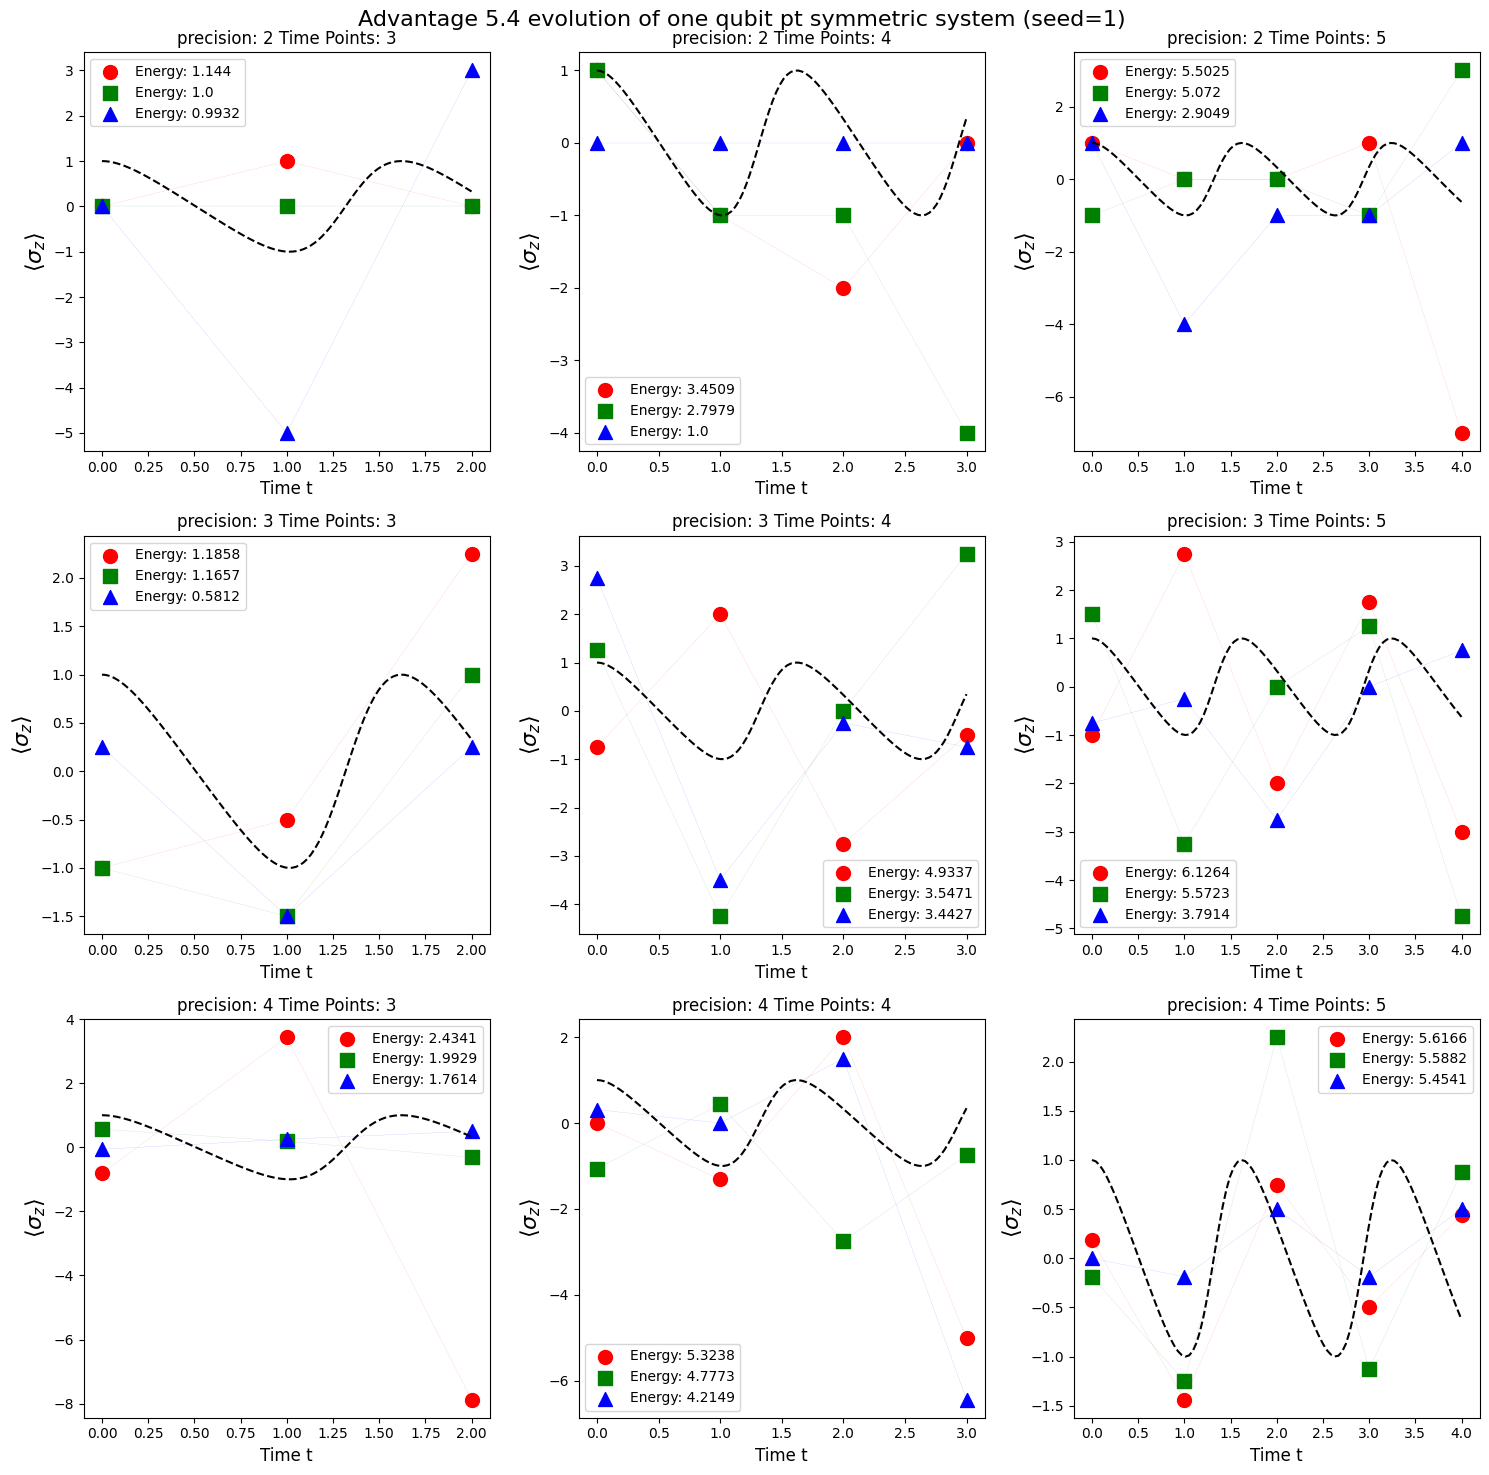

In [39]:
import qutip as qp

# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...

# Loop over all rows in velox_results and plot all dynamics on the same panel,
# coloring each curve according to its best_energy.
colors = ["r", "g", "b", "c", "m", "y", "k"]
markers = ["o", "s", "^", "D", "v", "<", ">"]

SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.


# Create a single axis for the plot
fig, axes = plt.subplots(3, 3, figsize=(15, 15), sharey=False)
axes = axes.flatten()

system_latex_dict = {
    1: 'H = $\frac{\pi}{2}\sigma_y$',
    3: 'one qubit pt symmetric system (seed=1)'
}



for i, (precision,timepoints) in enumerate(tp_pairs):

    #baseline 
    H_qp = ptsymmetric.generate_pt_symmetric_hamiltonian(1,seed=1)
    psi_0 = qp.basis(2, 0)
    #psi_0 = PSI0
    times = np.linspace(0, timepoints-1, 100)
    baseline = qp.mesolve(H_qp, psi_0, times, e_ops=[qp.sigmaz()]).expect[0]
    ax = axes[i]

    ax.plot(times, baseline, "k--")

    problem = ComplexDynamicsProblem(
        hamiltonian=H,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
        initial_state = PSI0,              # Starting at initial state |0>,
        times=tuple(range(timepoints)),             # With six time points 0,1,2
        num_bits_per_var=precision               # And two bits of precision per variable
    )

    dfs_filtered = dfs_data_raw[(dfs_data_raw.precision == precision) & (dfs_data_raw.timepoints == timepoints)]
    dfs_filtered = dfs_filtered.drop(['num_occurrences'],axis=1)
    dfs_filtered.drop_duplicates(inplace=True)
    dfs_filtered = dfs_filtered.sort_values(by='energy').head(3)
    dfs_filtered = dfs_filtered.sort_values(by='energy',ascending=False)
    energies = list(dfs_filtered['energy'])
    dfs_filtered = dfs_filtered.filter(regex='\d+')
    dfs_filtered = dfs_filtered.apply(pd.to_numeric)
    for j, (_, row) in enumerate(dfs_filtered.iterrows()): 
        sol_dict = row.dropna().to_dict()
        sol_dict = {key:int(value) for key,value in sol_dict.items()}

        vec =problem.interpret_sample(sol_dict)
        SZ = np.array([[1, 0], [0, -1]])

        expect = [(state.conj() @ SZ @ state).real for state in vec]
        ax.scatter(problem.times, expect, color=colors[j % len(colors)], marker=markers[j % len(markers)], label=f"Energy: {round(energies[j],4)}", alpha=1.0, s=100)
        ax.plot(problem.times, expect, color=colors[j % len(colors)], alpha=0.5, linewidth=0.1)
    ax.set_xlabel("Time t", fontsize=12)
    ax.set_ylabel(r"$\langle \sigma_z \rangle$", fontsize=16)
    ax.set_title(f"precision: {problem.num_bits_per_var} Time Points: {len(problem.times)}")


    ax.legend()
fig.suptitle(f"Advantage {topology} " +rf"evolution of {system_latex_dict[system]} ",fontsize=16)
plt.tight_layout()
plt.savefig(f'../plots/system{topology}_dynamic_{system}.pdf')
plt.show()



In [34]:
sol_dict = dfs_data_raw.iloc[0,:].dropna().to_dict()
sol_dict = {key:int(value) for key,value in sol_dict.items()}

# We simulate evolution under the Hamiltonian 1/2 pi * Sigma_y...
SY = np.array([[0, -1.0j], [1.0j, 0.0]])
PSI0 = np.array([1, 0], dtype=np.complex128)  # Difference b. Initial state can now be complex.

prec = 2
timepoints = 4
problem = ComplexDynamicsProblem(
    hamiltonian=0.5 * np.pi * SY,      # Evolution under hamiltonian 0.5 * np.pi * sigma_y
    initial_state = PSI0,              # Starting at initial state |0>,
    times=tuple(range(timepoints)),             # With six time points 0,1,2
    num_bits_per_var=prec               # And two bits of precision per variable
)
print(sol_dict)
vec =problem.interpret_sample(sol_dict)

{0: 1, 1: 0, 2: 0, 3: 1, 4: 0, 5: 1, 6: 0, 7: 1, 8: 0, 9: 1, 10: 0, 11: 1, 12: 1, 13: 0, 14: 0, 15: 1, 16: 0, 17: 0, 18: 0, 19: 1, 20: 0, 21: 1, 22: 0, 23: 1, 24: 0, 25: 1, 26: 0, 27: 1, 28: 0, 29: 0, 30: 0, 31: 1}


In [ ]:
SZ = np.array([[1, 0], [0, -1]])

expect = [(state.conj() @ SZ @ state).real for state in vec]

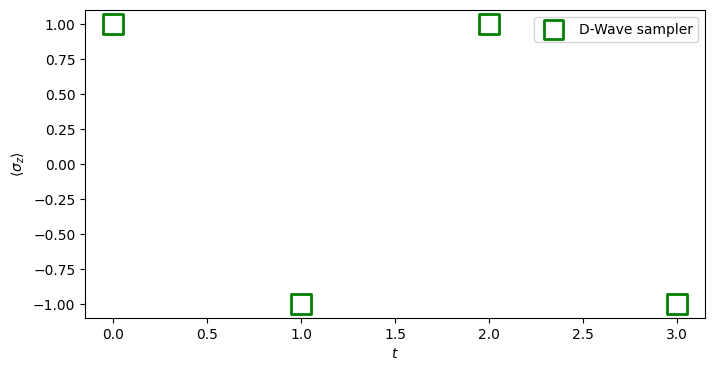

In [36]:
from matplotlib import pyplot as plt

fig, axis = plt.subplots(figsize=(8, 4))

#axis.plot(times, baseline, "k--", label="QuTiP (baseline)")

#axis.scatter(problem.times, exact_expect, marker="^", lw=2, s=300, edgecolors="b", facecolors="none", label="Exact solver")
#axis.scatter(problem.times, sa_expect, marker="o", lw=2, s=100, edgecolors="r", facecolors="none", label="SA sampler")
axis.scatter(problem.times, expect, marker="s", lw=2, s=200, edgecolors="g", facecolors="none", label="D-Wave sampler")

axis.set_ylabel(r"$\langle \sigma_z \rangle$")
axis.set_xlabel("$t$")
axis.legend()